# import libraries

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch.optim as optim

# Import CSV files

In [11]:
df1 = pd.read_csv("DataSet1.csv")
df2 = pd.read_csv("DataSet2.csv")
df3 = pd.read_csv("DataSet3.csv")

# Handle Values

In [12]:
#Drop missing values
df2.dropna(inplace=True)
df2.reset_index(drop=True, inplace=True)
print(df2.isnull().sum())

#Add BMI column for dataset3
df3["Height (m)"] = df3["Height (cm)"] / 100
df3["BMI"] = df3["Weight (kg)"] / (df3["Height (m)"] ** 2)
df3["BMI"] = df3["BMI"].round(2)

# Drop unneccessary columns to reduce redundancy
df3 = df3[df3["Gender"] != "Other"]
df1 = df1.drop(columns=["Weight (kg)","Height (m)","Workout_Type"])
df2 = df2.drop(columns=["Weight (kg)","Height (m)","Workout_Type"])
df3 = df3.drop(columns=["User ID","Workout Type","Mood Before Workout","Mood After Workout","VO2 Max","Height (m)",
                        "Workout Intensity","Weight (kg)","Height (cm)","Water Intake (liters)","Body Fat (%)"])
df3.reset_index(drop=True, inplace=True)

# Encode Gender
df1['Gender'] = df1['Gender'].map({'Male': 0, 'Female': 1})
df2['Gender'] = df2['Gender'].map({'Male': 0, 'Female': 1})
df3['Gender'] = df3['Gender'].map({'Male': 0, 'Female': 1})

#Turn unncesary float number to integer Ex: age, frequency, level
df2["Age"] = df2["Age"].round(0).astype(int)
df2["Workout_Frequency (days/week)"] = df2["Workout_Frequency (days/week)"].round(0).astype(int)
df2["Experience_Level"] = df2["Experience_Level"].round(0).astype(int)
df2["Calories_Burnedl"] = df2["Calories_Burned"].round(0).astype(int)





Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64


# Convert objects to numerical values

In [13]:
df2['Max_BPM'] = pd.to_numeric(df2['Max_BPM'], errors='coerce')
df2['BMI'] = pd.to_numeric(df2['BMI'], errors='coerce')

In [14]:
# Fill NaNs with column mean (you could also use median or other strategy)
df1 = df1.fillna(df1.mean(numeric_only=True))
df2 = df2.fillna(df2.mean(numeric_only=True))
df3 = df3.fillna(df3.mean(numeric_only=True))


# CNN Model

In [15]:
class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()

        # First 1D convolutional layer:
        # Takes input with 1 channel (since data is 1D)
        # Outputs 32 channels (feature maps)
        # Kernel size of 3 means it looks at 3 feature values at a time
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)

        # First ReLU activation adds non-linearity
        self.relu1 = nn.ReLU()

        # Max pooling layer reduces the size of the output and helps control overfitting
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Second convolutional layer:
        # Takes 32 input channels and produces 64 feature maps
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)

        # Second activation function
        self.relu2 = nn.ReLU()

        # Adaptive pooling layer reduces output to a fixed size (length 1) regardless of input length
        self.pool2 = nn.AdaptiveMaxPool1d(1)

        # Fully connected layer to map the flattened pooled features (64 units) to 32 hidden units
        self.fc1 = nn.Linear(64, 32)

        # Another ReLU to introduce non-linearity
        self.relu3 = nn.ReLU()

        # Output layer maps to a single value (calories burned)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        # Reshape input to (batch_size, channels, features)
        x = x.unsqueeze(1)

        # Apply first conv layer, ReLU, and pooling
        x = self.pool1(self.relu1(self.conv1(x)))

        # Apply second conv layer, ReLU, and adaptive pooling
        x = self.pool2(self.relu2(self.conv2(x)))

        # Flatten the output to feed into the fully connected layer
        x = x.view(x.size(0), -1)

        # Apply fully connected layer and ReLU
        x = self.relu3(self.fc1(x))

        # Final output (predicted calories)
        return self.out(x)



## Split Data

In [16]:
X1, y1 = df1.drop(columns="Calories_Burned"), df1["Calories_Burned"]
X2, y2 = df2.drop(columns="Calories_Burned"), df2["Calories_Burned"]
X3, y3 = df3.drop(columns="Calories Burned"), df3["Calories Burned"]

def split_dataset(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train_1, X_test_1, y_train_1, y_test_1 = split_dataset(X1, y1)
X_train_2, X_test_2, y_train_2, y_test_2 = split_dataset(X2, y2)
X_train_3, X_test_3, y_train_3, y_test_3 = split_dataset(X3, y3)


## Training function

In [17]:
def train_cnn(X_train, y_train, X_test):

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert the NumPy arrays to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    # Convert y_train into a tensor and reshape it to be a 2D column vector
    y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  

    # Create a dataset and data loader for mini-batch training
    train_dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  

    # Initialize the CNN model
    model = CNN1D(X_train.shape[1]) 

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Mean Squared Error is the loss function, ideal for regression problems
    criterion = nn.MSELoss()

    train_losses = []  # track average loss per epoch

    for epoch in range(50):
        model.train()  
        epoch_loss = 0 # Sum of losses for this epoch

        # Loop over each mini-batch
        for xb, yb in loader:
            pred = model(xb)              # Forward pass: predict using current model
            loss = criterion(pred, yb)    # Compute loss between predicted and actual
            optimizer.zero_grad()         # Reset gradients from previous step
            loss.backward()               # Backpropagation: compute gradients
            optimizer.step()              # Update weights based on gradients

            epoch_loss += loss.item()     # Add batch loss to epoch total

        # Compute average loss for this epoch
        avg_loss = epoch_loss / len(loader)
        train_losses.append(avg_loss)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Generate predictions on the test set (no gradient tracking needed)
    model.eval()
    with torch.no_grad():
        preds = model(X_test).numpy()  

    # Return predicted test values and list of training losses
    return preds, train_losses

In [18]:
y_pred_1, losses_1 = train_cnn(X_train_1, y_train_1, X_test_1)
y_pred_2, losses_2 = train_cnn(X_train_2, y_train_2, X_test_2)
y_pred_3, losses_3 = train_cnn(X_train_3, y_train_3, X_test_3)

Epoch 1, Loss: 892531.5725
Epoch 2, Loss: 865537.6050
Epoch 3, Loss: 792671.5675
Epoch 4, Loss: 622985.8488
Epoch 5, Loss: 326705.2406
Epoch 6, Loss: 94408.2616
Epoch 7, Loss: 57352.3125
Epoch 8, Loss: 54210.8673
Epoch 9, Loss: 52178.9052
Epoch 10, Loss: 51945.8913
Epoch 11, Loss: 49515.2277
Epoch 12, Loss: 47944.5782
Epoch 13, Loss: 45982.4287
Epoch 14, Loss: 44787.3791
Epoch 15, Loss: 43664.3503
Epoch 16, Loss: 44189.6827
Epoch 17, Loss: 41761.5522
Epoch 18, Loss: 40791.3148
Epoch 19, Loss: 40356.9745
Epoch 20, Loss: 39657.3841
Epoch 21, Loss: 37640.3886
Epoch 22, Loss: 36327.9549
Epoch 23, Loss: 35414.7220
Epoch 24, Loss: 34936.6126
Epoch 25, Loss: 33579.7665
Epoch 26, Loss: 33815.6242
Epoch 27, Loss: 31825.8530
Epoch 28, Loss: 31228.6548
Epoch 29, Loss: 30936.4171
Epoch 30, Loss: 30993.0685
Epoch 31, Loss: 28971.0359
Epoch 32, Loss: 28420.0653
Epoch 33, Loss: 27400.1995
Epoch 34, Loss: 26373.4527
Epoch 35, Loss: 26183.9491
Epoch 36, Loss: 25344.4604
Epoch 37, Loss: 25126.2422
Epoch

In [19]:
mae_1 = mean_absolute_error(y_test_1, y_pred_1)
mae_2 = mean_absolute_error(y_test_2, y_pred_2)
mae_3 = mean_absolute_error(y_test_3, y_pred_3)

mse_1 = mean_squared_error(y_test_1, y_pred_1)
mse_2 = mean_squared_error(y_test_2, y_pred_2)
mse_3 = mean_squared_error(y_test_3, y_pred_3)

r2_1 = r2_score(y_test_1, y_pred_1)
r2_2 = r2_score(y_test_2, y_pred_2)
r2_3 = r2_score(y_test_3, y_pred_3)

print(f"Dataset1: mae_score: {mae_1} mse_score: {mse_1} r2_score: {r2_1}")
print(f"Dataset2: mae_score: {mae_2} mse_score: {mse_2} r2_score: {r2_2}")
print(f"Dataset3: mae_score: {mae_3} mse_score: {mse_3} r2_score: {r2_3}")

Dataset1: mae_score: 96.44747971754808 mse_score: 14435.219785113431 r2_score: 0.8269677512929086
Dataset2: mae_score: 246.58935187844668 mse_score: 92058.96889189494 r2_score: 0.10333480638685588
Dataset3: mae_score: 223.73341768989044 mse_score: 66989.65309490541 r2_score: -0.011017918586730957


## Data Visualization

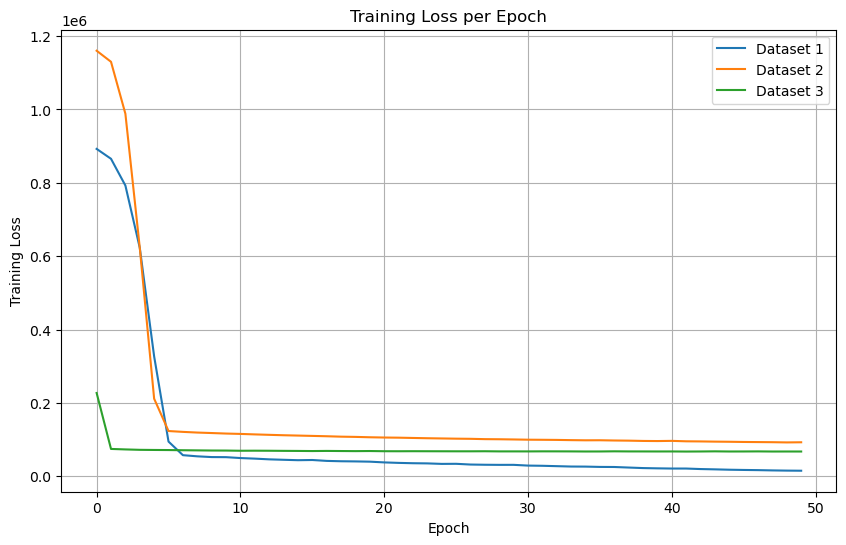

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(losses_1, label="Dataset 1")
plt.plot(losses_2, label="Dataset 2")
plt.plot(losses_3, label="Dataset 3")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

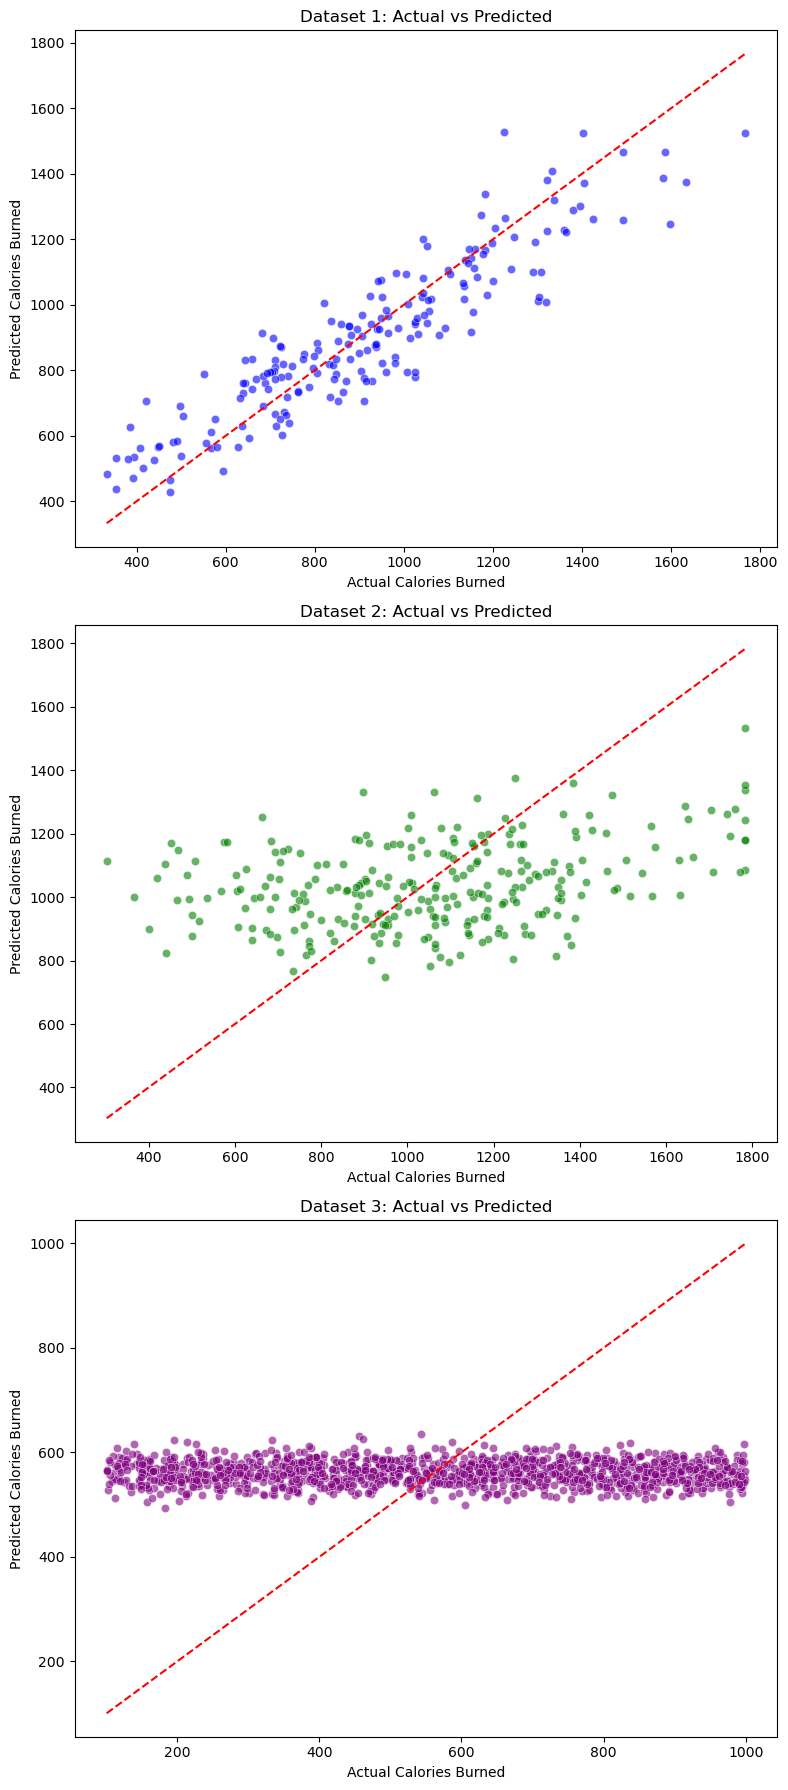

In [21]:

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))

# Scatter plot for Dataset 1
sns.scatterplot(x=y_test_1, y=y_pred_1.flatten(), ax=axes[0], color="blue", alpha=0.6)
axes[0].plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], color='red', linestyle='--')
axes[0].set_title("Dataset 1: Actual vs Predicted")
axes[0].set_xlabel("Actual Calories Burned")
axes[0].set_ylabel("Predicted Calories Burned")

# Scatter plot for Dataset 2
sns.scatterplot(x=y_test_2, y=y_pred_2.flatten(), ax=axes[1], color="green", alpha=0.6)
axes[1].plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], color='red', linestyle='--')
axes[1].set_title("Dataset 2: Actual vs Predicted")
axes[1].set_xlabel("Actual Calories Burned")
axes[1].set_ylabel("Predicted Calories Burned")

# Scatter plot for Dataset 3
sns.scatterplot(x=y_test_3, y=y_pred_3.flatten(), ax=axes[2], color="purple", alpha=0.6)
axes[2].plot([min(y_test_3), max(y_test_3)], [min(y_test_3), max(y_test_3)], color='red', linestyle='--')
axes[2].set_title("Dataset 3: Actual vs Predicted")
axes[2].set_xlabel("Actual Calories Burned")
axes[2].set_ylabel("Predicted Calories Burned")

plt.tight_layout()
plt.show()